## 实验二   神经网络
### 第2题   使用TensorFlow建立一个3层神经网络（如，13×50×1），对wine数据集（wine_data-2.csv）进行分类

In [ ]:
#  2023.3.20
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import csv

In [15]:
# 加载数据
array1 = []
array2 = []
train = []
train_labels = []
test = []
test_labels = []

with open('wine_data-2.csv', mode='r') as file:
    # reading the CSV file
    csvFile = csv.reader(file, delimiter=',')
    header=next(csvFile)  # 忽略第1行
    
    # displaying the contents of the CSV file
    len = 1   
    for lines in csvFile: 
        subarray = []
        if len < 60:    #1到59为标签为0的数据
            for i in range(14):
                subarray.append(float(lines[i]))
            array1.append(subarray) #拿到全部标签为0的数据
            
        if len > 59 and len < 131: #60到130为标签为1的数据
            for i in range(14):
                subarray.append(float(lines[i]))
            array2.append(subarray)#拿到全部标签为1的数据
        len += 1

    np.random.shuffle(array1) #乱序
    np.random.shuffle(array2)
 
    data1, data2 = tf.split(array1, [47, 12], 0) # 从标签0的数据中取80%做训练数据，约20%做测试数据
    data3, data4 = tf.split(array2, [56, 15], 0) # 从标签1的数据中取80%做训练数据，约20%做测试数据
    
    train1, train_labels1 = tf.split(data1, [13, 1], 1) #分出标签
    train2, train_labels2 = tf.split(data3, [13, 1], 1) #分出标签
    
    test1, test_labels1 = tf.split(data2, [13, 1], 1) #分出标签
    test2, test_labels2 = tf.split(data4, [13, 1], 1) #分出标签
    
    train = tf.concat([train1, train2], 0)   #把两类训练数据合并
    
    train_labels = tf.concat([train_labels1, train_labels2], 0) #把训练集的标签合并
    test = tf.concat([test1, test2], 0) #把两类测试数据合并
    test_labels = tf.concat([test_labels1, test_labels2], 0) #把测试集的标签合并
    
    #train_labels = tf.squeeze(train_labels, axis=1)  #消去标签集的第二维度(103, 1)->(103,0)
    #test_labels = tf.squeeze(test_labels, axis=1)
    

def train_preprocess(x_train, y_train):
    x_train = tf.cast(x=x_train, dtype=tf.float32) / 100.0  #对数据的值进行缩放，加速拟合
    y_train = tf.cast(x=y_train, dtype=tf.int32)
    return x_train, y_train


def test_preprocess(x_test, y_test):
    x_test = tf.cast(x=x_test, dtype=tf.float32) / 100.0 #对数据的值进行缩放，加速拟合
    y_test = tf.cast(x=y_test, dtype=tf.int32)
    return x_test, y_test


train_db = tf.data.Dataset.from_tensor_slices(tensors=(train, train_labels)) #封装训练
train_db = train_db.map(map_func=train_preprocess).shuffle(buffer_size=103).batch(batch_size=13)

test_db = tf.data.Dataset.from_tensor_slices(tensors=(test, test_labels))
test_db = test_db.map(map_func=test_preprocess).shuffle(buffer_size=27).batch(batch_size=27)

In [16]:
# 建立神经网络模型（13×50×1）
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=50, activation=tf.nn.relu, use_bias=True, kernel_initializer='glorot_uniform',
                          bias_initializer='zeros'),
    tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid, use_bias=True, kernel_initializer='glorot_uniform',
                          bias_initializer='zeros')
])
model.build(input_shape=[None, 13])
model.summary()

#优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0)
# learning_rate：float> = 0.学习率；
# beta_1：float，0 <beta <1。一般接近1。一阶矩估计的指数衰减率；
# beta_2：float，0 <beta <1。一般接近1。二阶矩估计的指数衰减率；
# epsilon：float> = 0,模糊因子。如果None，默认为K.epsilon()。该参数是非常小的数，其为了防止在实现中除以零。
# decay：float> = 0,每次更新时学习率下降

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                700       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 751
Trainable params: 751
Non-trainable params: 0
_________________________________________________________________


In [17]:
acc = []
ep = []

#训练神经网络
for epoch in range(200):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            logits = model(x_train)
            loss = tf.keras.losses.mean_squared_error(y_train, logits)  # 使用均方误差作为损失函数
            tape.watch(model.trainable_variables)
        gradient = tape.gradient(target=loss, sources=model.trainable_variables)#梯度下降
        optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    total_num = 0
    
    #测试神经网络
    for step, (x_test, y_test) in enumerate(test_db):
        logits = model(x_test)
        logits = tf.squeeze(logits, 1)#消去第二个维度(27, 1)->(27,0)
        y_test = tf.squeeze(y_test, 1)#消去第二个维度(27, 1)->(27,0)
        
        for i in range(logits.shape[0]):
            part1 = logits[:i]
            part2 = logits[i + 1:]
            val = []
            if logits[i] > 0.5: # 对模型输出结果大于0.5的认为是标签为是1的数据
                val = tf.constant([1], tf.float32)
            else:
                val = tf.constant([0], tf.float32)  # 对模型输出结果小于等于0.5的认为是标签为是0的数据
            logits = tf.concat([part1, val, part2], axis=0)
        
        prediction = tf.cast(x=logits, dtype=tf.int32) # 把预测结果转为tf.int32类型
        correct = tf.equal(x=prediction, y=y_test)  # 获得一个一维向量，其中值为1表示预测正确
        correct = tf.cast(x=correct, dtype=tf.int32)
        
        correct = tf.reduce_sum(input_tensor=correct)  # 获得每个epoch训练完后预测正确的数据的个数
        total_num = x_test.shape[0]
        
    accuracy = correct / total_num
    acc.append(accuracy)#收集每个epoch在测试集上的准确度
    ep.append(epoch)#收集对应的epoch

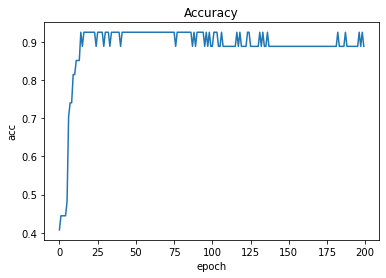

In [18]:
# 绘制 测试精度VS训练轮次 的曲线
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(ep, acc)
plt.show()